## Kalman Filter Algorithm

The algorithm is the same Bayesian filter algorithm that we have used in every chapter. The update step is slightly more complicated, but I will explain why when we get to it.

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based
    on scaling factor
    5. update belief in the state based on how certain we are
    in the measurement

Import necessary libraries

In [46]:
!pip install pykalman

In [47]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

Read file

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2011-2024completefinaldatasets.csv')
df.head()

,Time,Rainfall,Temperature,Humidity,Cases
0,2011-w1,9.938571,29.444400,86.242857,5
1,2011-w2,8.587143,30.000000,88.028571,4
2,2011-w3,5.338571,30.000000,84.028571,2
3,2011-w4,5.410000,30.555556,80.971429,7
4,2011-w5,2.914286,28.333333,74.885714,2


Convert Time to proper date format

In [50]:
# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'] + '-1', format='%Y-w%W-%w')

*Prepare the data*

In [51]:
y = df['Cases'].values  # Dependent variable (cases)
X = df[['Rainfall', 'Temperature', 'Humidity']].values  # Regressors

 Split data into 80% train and 20% test


In [52]:
train_size = int(len(df) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

 Add intercept (column of ones) to the observation matrix for training and Reshape to be compatible with Kalman Filter (n_timesteps, 1, n_regressors + 1)


In [53]:
# Kalman Filter Setup
n_timesteps_train, n_regressors = X_train.shape

# Create the observation matrices for the training data (including intercept term)
observation_matrices_train = np.array([np.concatenate(([1], X_train[i])) for i in range(n_timesteps_train)])
observation_matrices_train = observation_matrices_train.reshape((n_timesteps_train, 1, n_regressors + 1))

# Set initial state mean and covariance
initial_state_mean = np.zeros(n_regressors + 1)  # State for intercept and coefficients
initial_state_covariance = np.eye(n_regressors + 1)  # Identity matrix

Define the Kalman Filter

In [54]:
# Increased the observation covariance to allow more uncertainty
observation_covariance = 10.0  # Increase measurement noise to prevent overfitting
transition_covariance = 0.1 * np.eye(n_regressors + 1)  # Increased transition noise

In [55]:
# Create Kalman Filter with adjusted parameters
kf = KalmanFilter(
    transition_matrices=np.eye(n_regressors + 1),  # Identity matrix for state transition
    observation_matrices=observation_matrices_train,  # Observation matrix
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,  # Increased noise
    transition_covariance=transition_covariance  # Increased noise
)

Train the Kalman Filter on the training set and Predict on the test set using the state means from training

In [56]:
# Train the Kalman Filter on the training set
state_means_train, state_covariances_train = kf.em(y_train, n_iter=10).smooth(y_train)

Actual vs predicted cases

In [57]:
# Generate Predictions for the Test Set
# Create observation matrices for the test set
n_timesteps_test = X_test.shape[0]
observation_matrices_test = np.array([np.concatenate(([1], X_test[i])) for i in range(n_timesteps_test)])
observation_matrices_test = observation_matrices_test.reshape((n_timesteps_test, 1, n_regressors + 1))

In [58]:
# Regression prediction on training set
predicted_cases_train = np.dot(observation_matrices_train.squeeze(), state_means_train.T).diagonal()

In [59]:
# Prediction for the test set (regression output)
predicted_cases_test = np.dot(observation_matrices_test.squeeze(), state_means_train.T).diagonal()

In [60]:
# Results DataFrame for training set
results_df_train = pd.DataFrame({
    'Actual Cases': y_train,
    'Forecasted Cases': predicted_cases_train
})

print("Training Set Results:")
print(results_df_train.head())

# Results DataFrame for test set
results_df_test = pd.DataFrame({
    'Actual Cases': y_test,
    'Forecasted Cases': predicted_cases_test
})

print("Test Set Results:")
print(results_df_test.head())

Training Set Results:
   Actual Cases  Forecasted Cases
0             5          4.956347
1             4          3.983246
2             2          2.333310
3             7          6.487273
4             2          2.418239
Test Set Results:
   Actual Cases  Forecasted Cases
0             3          2.964633
1             1          2.236467
2             1          1.876047
3             1          5.535241
4             1          2.395968


Display visualition for actual vs predicted cases

In [61]:
# --- Train Set Metrics ---
# Regression metrics
mse_train = mean_squared_error(y_train, predicted_cases_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, predicted_cases_train)

print('\n--- Train Set Regression Metrics ---')
print(f'Mean Squared Error (MSE): {mse_train}')
print(f'Root Mean Squared Error (RMSE): {rmse_train:.6f}')
print(f'Mean Absolute Error (MAE): {mae_train}')


--- Train Set Regression Metrics ---
Mean Squared Error (MSE): 0.4987340620666296
Root Mean Squared Error (RMSE): 0.706211
Mean Absolute Error (MAE): 0.41042037920299373


In [62]:
# --- Test Set Metrics ---
mse_test = mean_squared_error(y_test, predicted_cases_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, predicted_cases_test)

print('\n--- Test Set Regression Metrics ---')
print(f'Mean Squared Error (MSE): {mse_test}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.6f}')
print(f'Mean Absolute Error (MAE): {mae_test}')


--- Test Set Regression Metrics ---
Mean Squared Error (MSE): 1484.3149421882667
Root Mean Squared Error (RMSE): 38.526808
Mean Absolute Error (MAE): 22.40045270442006


Evaluate the Kalman Filter performance


In [63]:
# Print Results
print('\n--- Train Set Metrics ---')
print(f'Mean Squared Error (MSE): {mse_train}')
print(f'Root Mean Squared Error (RMSE): {rmse_train:.6f}')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n--- Test Set Metrics ---')
print(f'Mean Squared Error (MSE): {mse_test}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.6f}')
print(f'Mean Absolute Error (MAE): {mae_test}')


--- Train Set Metrics ---
Mean Squared Error (MSE): 0.4987340620666296
Root Mean Squared Error (RMSE): 0.706211
Mean Absolute Error (MAE): 0.41042037920299373

--- Test Set Metrics ---
Mean Squared Error (MSE): 1484.3149421882667
Root Mean Squared Error (RMSE): 38.526808
Mean Absolute Error (MAE): 22.40045270442006


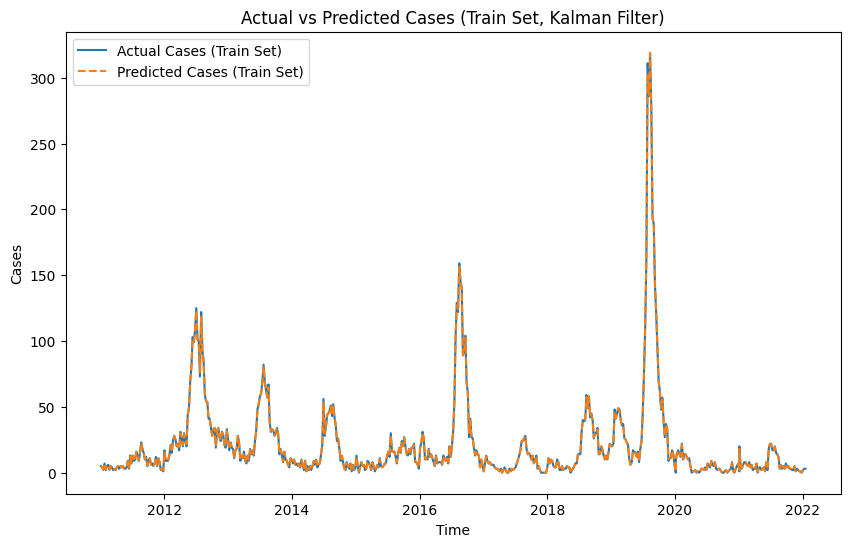

In [64]:
# Plot actual vs predicted cases for training set
plt.figure(figsize=(10, 6))
plt.plot(df['Time'][:train_size], y_train, label='Actual Cases (Train Set)')
plt.plot(df['Time'][:train_size], predicted_cases_train, label='Predicted Cases (Train Set)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.title('Actual vs Predicted Cases (Train Set, Kalman Filter)')
plt.show()

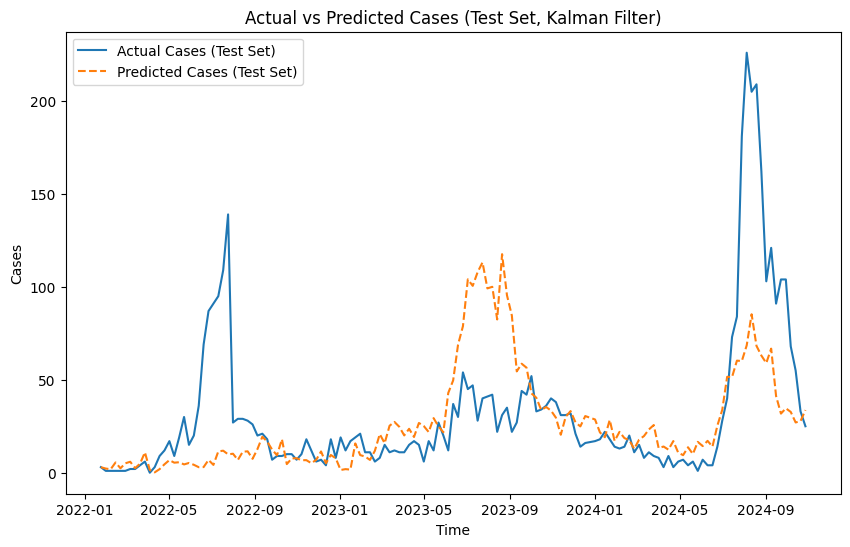

In [65]:
# Plot actual vs predicted cases for test set
plt.figure(figsize=(10, 6))
plt.plot(df['Time'][train_size:], y_test, label='Actual Cases (Test Set)')
plt.plot(df['Time'][train_size:], predicted_cases_test, label='Predicted Cases (Test Set)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.title('Actual vs Predicted Cases (Test Set, Kalman Filter)')
plt.show()